In [136]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from qiskit.primitives import Sampler,Estimator
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
%matplotlib inline

In [2]:
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
# from qulacs import QuantumState, QuantumCircuit
# from qulacs.gate import X, Y, Z, RX, RY, RZ, CNOT, H, to_matrix_gate, merge, add
# from qulacs import Observable
# from qulacsvis import circuit_drawer

In [134]:
def add_RZZ_gate(circuit,sub_qubits,param):
    '''
    add exp(i\alpha ZZ/2) to the circuit
    input:
    - circuit: quantum circuit as QuantumCircuit
    - sub_qubits: indices of qubits on which RZZ gate acts
    - param: angle (\alpha)
    '''
    circuit.cx(sub_qubits[0],sub_qubits[1])
    circuit.rz(param,sub_qubits[1])
    circuit.cx(sub_qubits[0],sub_qubits[1])
    
def make_ansatz_HVA(params,num_qubits,num_layers):
    '''
    construct Hamiltonian variational ansatz
    - input
        - num_qubits: number of qubits (N)
        - num_layers: number of layers (L)
        - params: list parameters (number of parameters: (3*num_qubits-2)*num_layers)
    - output: ansatz as QuantumCircuit
    '''
    circuit = QuantumCircuit(num_qubits)

    params_index = 0
    for layer in range(num_layers):

        #RZZ even
        for qubit in range(0,num_qubits-1,2):
            add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
        #RZZ odd
        for qubit in range(1,num_qubits-1,2):
            add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
        #RX
        for qubit in range(num_qubits):
            circuit.rx(params[params_index],qubit)
            params_index += 1
    return circuit

## construct quantum circuit for computing matrices $A_{ij}$ and $C_i$
$A_{ij}$ and $C_{i}$ are defined by
$$
A_{ij} = \frac{\partial \langle \psi|}{\partial \theta_{i}} \frac{\partial  |\psi\rangle}{\partial \theta_{j}}
,\quad
C_{i} = \frac{\partial \langle \psi|}{\partial \theta_{i}} H |\psi\rangle\,.
$$

In time dependent variational principle (TDVP), we are instrested in the imaginary (real) part of $A_{ij}$ ($C_{i}$).
$$ M_{ij} := i A_{ij} +\text{h.c.} = 2 \text{Re}[i A_{ij}]
,\quad
V_{i} := C_{i} +\text{h.c.} = 2 \text{Re}[C_{i}]\,.
$$

They can be computed by the circuit given in FIG. 2 in [Li-Benjamin].
- for $M_{ij}$, $a=1/2, \theta=\pi/2$
- for $V_{i}$, $a=1\times(\text{coeff. in Hamiltonian}), \theta = -\pi/2$

On the other hand, in MacLaclan's variational princle, we need
$$ M_{ij} := A_{ij} +\text{h.c.} = 2 \text{Re}[A_{ij}]
,\quad
V_{i} := -i C_{i} +\text{h.c.} = 2 \text{Re}[(-i)C_{i}]\,.
$$

Thus the corresponding coefficients in FIG. 2 in [Li-Benjamin] are given by
- for $M_{ij}$, $a=1/2, \theta=0$
- for $V_{i}$, $a=\red{-1}\times(\text{coeff. in Hamiltonian}), \theta = \red{0}$ (**Changed convention. Dec.12, 2022. Results are same** )

In [4]:
def add_conditional_RX_gate(circuit,qubit_ancilla, qubit_target, param, params_index,deriv_index_list):
    ''' 
    if params_index is equal to one element in deriv_index_list, then add RZ.CZ to circuit (instead of RZ)
    - input:
        - circuit: quantum circuit
        - qubit_ancilla: index of ancilla qubit
        - qubit_target: index of target qubit (on which RZ acts on)
        - param: rotation angle
        - params_index: index of parameter
        - deriv_index_list: list of index [i,j] wrt which we take derivative (i<j)
    -output: None
    '''
    #derivative wrt RZ gate
    if deriv_index_list[0] == params_index or deriv_index_list[1] == params_index:
        circuit.x(qubit_ancilla) #add X gate
        circuit.cx(qubit_ancilla,qubit_target) #add CX gate 
    circuit.rx(param,qubit_target) #add RX gate

In [5]:
def add_conditional_RZZ_gate(circuit,qubit_ancilla, qubits_target, param, params_index,deriv_index_list):
    ''' 
    if params_index is equal to one element in deriv_index_list, then add RZ.CZ to circuit (instead of RZ) two between CNOTs
    - input:
        - circuit: quantum circuit
        - qubit_ancilla: index of ancilla qubit
        - qubits_target: list of indices of target qubits (on which RZ acts on)
        - param: rotation angle
        - params_index: index of parameter
        - deriv_index_list: list of index [i,j] wrt which we take derivative (i<j)
    -output: None
    '''
    #derivative wrt RZ gate
    circuit.cx(qubits_target[0],qubits_target[1])
    if deriv_index_list[0] == params_index or deriv_index_list[1] == params_index:
        circuit.x(qubit_ancilla) #add X gate
        circuit.cz(qubit_ancilla,qubits_target[1]) #add CZ gate 
    circuit.rz(param,qubits_target[1]) #add RZ gate
    circuit.cx(qubits_target[0],qubits_target[1])

In [15]:
def make_M_circuit_HVA(params,num_qubits,num_layers,deriv_index_list):
    '''
    circuit for M_{ij}
    - input
        - num_qubits: number of qubits (N)
        - num_layers: number of layers (L)
        - params: list parameters (\theta) (number of parameters: 2*num_qubits*num_layers)
        - deriv_index_list (list): indices for parameters which we want to take derivative with respect to. ([i,j] for M_{ij}. (i<j))
    - output: quantum circuit
    '''
    circuit = QuantumCircuit(num_qubits+1,1) #make quantum circuit with N-registers and 1-ancilla, and a classical qubit
    qubit_ancilla = num_qubits #ancilla in last qubit

    #make initial state in physical qubits
    # for qubit in range(num_qubits):
    #     circuit.add_H_gate(qubit)

    circuit.h(qubit_ancilla) # make (|0>+|1>)/sqrt(2) in ancilla
    # circuit.add_S_gate(qubit_ancilla) # make (|0>+i|1>)/sqrt(2) as an initial state (eta=1 in Li-Benjamin) in ancilla

    params_index = 0
    for layer in range(num_layers):
        #RZZ even
        for qubit in range(0,num_qubits-1,2):
            add_conditional_RZZ_gate(circuit,qubit_ancilla, [qubit,qubit+1], params[params_index], params_index,deriv_index_list)
            # add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
        #RZZ odd
        for qubit in range(1,num_qubits-1,2):
            add_conditional_RZZ_gate(circuit,qubit_ancilla, [qubit,qubit+1], params[params_index], params_index,deriv_index_list)
            # add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
        #RX 
        for qubit in range(num_qubits):
            add_conditional_RX_gate(circuit,qubit_ancilla, qubit, params[params_index], params_index,deriv_index_list)
            # circuit.add_RZ_gate(qubit,params[params_index])
            params_index += 1

    circuit.h(qubit_ancilla) #basis rotation for measurements in {|+>, |->} basis 
    circuit.measure(qubit_ancilla,0)
    return circuit

In [224]:
def make_V_circuit_HVA(params,num_qubits,num_layers,deriv_index):
    '''
    circuit for V_{i}
    - input
        - num_qubits: number of qubits (N)
        - num_layers: number of layers (L)
        - params: list parameters (\theta) (number of parameters: 2*num_qubits*num_layers)
        - deriv_index: index of a parameter with respect to which we want to take derivative. (i for V_{i})
    - output: dictionary of quantum circuit
        - key: terms in Hamiltonian (str)
        - value: quantum circuit corresponding to the key
    '''
    circuit = QuantumCircuit(num_qubits+1,1) #N-register + ancilla
    qubit_ancilla = num_qubits #ancilla in last qubit

    #make initial state in physical qubits
    # for qubit in range(num_qubits):
    #     circuit.add_H_gate(qubit)
        
    circuit.h(qubit_ancilla) # make (|0>+|1>)/sqrt(2) in ancilla qubit #changed, Dec. 12, 2022

    deriv_index_list = [deriv_index,len(params)*10]
    params_index = 0
    for layer in range(num_layers):
        #RZZ even
        for qubit in range(0,num_qubits-1,2):
            add_conditional_RZZ_gate(circuit,qubit_ancilla, [qubit,qubit+1], params[params_index], params_index,deriv_index_list)
            # add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
        #RZZ odd
        for qubit in range(1,num_qubits-1,2):
            add_conditional_RZZ_gate(circuit,qubit_ancilla, [qubit,qubit+1], params[params_index], params_index,deriv_index_list)
            # add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
    
        #RZ 
        for qubit in range(num_qubits):
            add_conditional_RX_gate(circuit,qubit_ancilla, qubit, params[params_index], params_index,deriv_index_list)
            # circuit.add_RZ_gate(qubit,params[params_index])
            params_index += 1

    #make quantum circuits for each term {h_j} in Hamiltonian
    #circuit_dict = {}
    circuit_dict=[]
    #X term in Hamiltonian
    for qubit in range(num_qubits):
        #term = f"X {qubit}"
        circuit_x = circuit.copy() #copy circuit
        circuit_x.x(qubit_ancilla) #add X gate
        circuit_x.cx(qubit_ancilla,qubit) #add control-h_j (here h_j = X)
        circuit_x.h(qubit_ancilla) #basis rotation for measurements in {|+>, |->} basis
        circuit_x.measure(qubit_ancilla,0)
        circuit_dict.append(circuit_x)

    #ZZ term in Hamiltonian
    for qubit in range(num_qubits-1):
        #term = f"Z {qubit} Z {qubit+1}"
        circuit_zz = circuit.copy() #copy circuit
        circuit_zz.x(qubit_ancilla) #add X gate
        circuit_zz.cz(qubit_ancilla,qubit) #add control-h_j (here h_j = ZZ)
        circuit_zz.cz(qubit_ancilla,qubit+1) #add control-h_j (here h_j = ZZ)
        circuit_zz.h(qubit_ancilla) #basis rotation for measurements in {|+>, |->} basis
        circuit_zz.measure(qubit_ancilla,0)
        circuit_dict.append(circuit_zz)
    return circuit_dict

When we include global phase, we have the following correction terms.
$$
M_{ij} \to M_{ij}-\frac{1}{2}\gamma_{i}\gamma_{j}\,,
$$
$$
V_{i} \to V_{i}+\gamma_{i}{\langle H\rangle}_{\psi}\,,
$$
where $\gamma_{i} = \text{Re}\left[\hat{U}_{i} U\right]$, ${\langle H\rangle}_{\psi}=\langle\psi|H|\psi\rangle$.
The correction vector $\gamma_{i}$ can be evaluated by the same circuit for $V_{i}$ with a replacement $H\to I$.
The initial state in the ancilla qubit is determined by $a=1$ and $\theta=\red{0}$.

**AN ERROR IS CORRECTED, ($\theta=\pi/2\to0$), Nov.30, 2022** 

In [225]:
def add_conditional_RX_gate(circuit,qubit_ancilla, qubit_target, param, params_index,deriv_index_list):
    ''' 
    if params_index is equal to one element in deriv_index_list, then add RZ.CZ to circuit (instead of RZ)
    - input:
        - circuit: quantum circuit
        - qubit_ancilla: index of ancilla qubit
        - qubit_target: index of target qubit (on which RZ acts on)
        - param: rotation angle
        - params_index: index of parameter
        - deriv_index_list: list of index [i,j] wrt which we take derivative (i<j)
    -output: None
    '''
    #derivative wrt RZ gate
    if deriv_index_list[0] == params_index or deriv_index_list[1] == params_index:
        circuit.x(qubit_ancilla) #add X gate
        circuit.cx(qubit_ancilla,qubit_target) #add CX gate 
    circuit.rx(param,qubit_target) #add RX gate

In [226]:
def add_conditional_RZZ_gate(circuit,qubit_ancilla, qubits_target, param, params_index,deriv_index_list):
    ''' 
    if params_index is equal to one element in deriv_index_list, then add RZ.CZ to circuit (instead of RZ) two between CNOTs
    - input:
        - circuit: quantum circuit
        - qubit_ancilla: index of ancilla qubit
        - qubits_target: list of indices of target qubits (on which RZ acts on)
        - param: rotation angle
        - params_index: index of parameter
        - deriv_index_list: list of index [i,j] wrt which we take derivative (i<j)
    -output: None
    '''
    #derivative wrt RZ gate
    circuit.cx(qubits_target[0],qubits_target[1])
    if deriv_index_list[0] == params_index or deriv_index_list[1] == params_index:
        circuit.x(qubit_ancilla) #add X gate
        circuit.cz(qubit_ancilla,qubits_target[1]) #add CZ gate 
    circuit.rz(param,qubits_target[1]) #add RZ gate
    circuit.cx(qubits_target[0],qubits_target[1])

In [227]:
def make_correction_circuit_HVA(params,num_qubits,num_layers,deriv_index):
    '''
    circuit for gamma_{i}
    - input
        - num_qubits: number of qubits (N)
        - num_layers: number of layers (L)
        - params: list parameters (\theta) (number of parameters: (3*num_qubits-2)*num_layers)
        - deriv_index: index of a parameter with respect to which we want to take derivative. (i for V_{i})

    '''
    circuit = QuantumCircuit(num_qubits+1,1) #N-register + ancilla
    qubit_ancilla = num_qubits #ancilla in last qubit

    # for qubit in range(num_qubits):
    #     circuit.add_H_gate(qubit)
    circuit.h(qubit_ancilla) # make (|0>+|1>)/sqrt(2) in ancilla qubit # fixed Nov. 29
    
    deriv_index_list = [deriv_index,len(params)*10]
    params_index = 0
    for layer in range(num_layers):
        #RZZ even
        for qubit in range(0,num_qubits-1,2):
            add_conditional_RZZ_gate(circuit,qubit_ancilla, [qubit,qubit+1], params[params_index], params_index,deriv_index_list)
            # add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
        #RZZ odd
        for qubit in range(1,num_qubits-1,2):
            add_conditional_RZZ_gate(circuit,qubit_ancilla, [qubit,qubit+1], params[params_index], params_index,deriv_index_list)
            # add_RZZ_gate(circuit,[qubit,qubit+1],params[params_index])
            params_index += 1
        #RX
        for qubit in range(num_qubits):
            add_conditional_RX_gate(circuit,qubit_ancilla, qubit, params[params_index], params_index,deriv_index_list)
            # circuit.add_RZ_gate(qubit,params[params_index])
            params_index += 1

    circuit.x(qubit_ancilla) #add X gate
    circuit.h(qubit_ancilla) #basis rotation for measurements in {|+>, |->} basis
    circuit.measure(qubit_ancilla,0)
    return circuit

In [294]:
def compute_M_matrix_HVA(params,num_qubits,num_layers,nShots=nShots,sampler = sampler):
    '''
    compute M_{ij}
    - input
        - num_qubits: number of qubits (N)
        - num_layers: number of layers (L)
        - params: list parameters (\theta) (number of parameters: 2*num_qubits*num_layers)
    - output: M_{ij} as numpy array
    '''
    num_params = len(params)
    M_mat = np.zeros((num_params,num_params)) # as numpy array
    qubit_ancilla = num_qubits
    for i in range(num_params-1):
        for j in range(i+1,num_params):
            deriv_index_list = [i,j]
            
            circuit_M = make_M_circuit_HVA(params,num_qubits,num_layers,deriv_index_list)
            circuit_corr1 = make_correction_circuit_HVA(params,num_qubits,num_layers,deriv_index_list[0])
            circuit_corr2 = make_correction_circuit_HVA(params,num_qubits,num_layers,deriv_index_list[1])
            
            job=sampler.run([circuit_M , circuit_corr1, circuit_corr2],shots=nShots)
            result=job.result()
            
            zero_prob = result.quasi_dists[0][0] 
            zero_prob_corr1 = result.quasi_dists[1][0] 
            zero_prob_corr2 = result.quasi_dists[2][0] 
            gamma1 = (2*zero_prob_corr1 - 1)
            gamma2 = (2*zero_prob_corr2 - 1)
            
            M_mat_element = (2*zero_prob- 1)/2 - gamma1*gamma2/2
            M_mat[i,j] = M_mat_element
            
    for i in range(num_params):
        circuit_correction = make_correction_circuit_HVA(params,num_qubits,num_layers,i)
        job=sampler.run([circuit_correction],shots=nShots)
        result=job.result()
        zero_probability_correction = result.quasi_dists[0][0] 
        gamma = (2*zero_probability_correction - 1)
        M_mat[i,i] = 1/2 - (gamma**2)/2 
        
    for i in range(num_params):
        for j in range(i):
            M_mat[i,j] = M_mat[j,i]
    return M_mat

In [296]:
circuit_M = make_M_circuit_HVA(params_init,num_qubits,num_layers,[1,2])

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


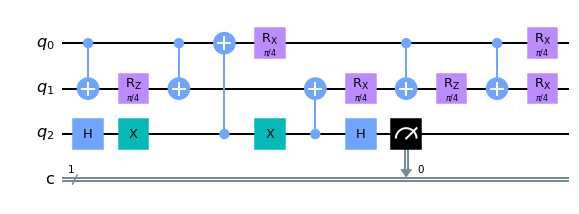

In [297]:
circuit_M.draw('mpl')

In [298]:
def make_coeff_dict(num_qubits,j_coupling,h_coupling):
    '''
    make coefficient dictionary from Hamiltonian
    - input:
        - num_qubits: number of qubits (N)
        - j_coupling: coefficient of ZZ terms (J)
        - h_coupling: coefficient of X terms (h)
    - output: coefficient dictionary
        - key: terms in Hamiltonian (str)
        - value: coresponding coefficient
    '''
    # w = 1/2/a #coeff in front of fermion kin. term
    # j_coupling = g*g*a/2 #coeff in front of gauge kin. term

    #make output dictionary 
    #coeff_dict = {}
    coeff_dict = []

    #X terms
    for i in range(num_qubits):
        #term = f"X {i}"
        coeff_dict.append( -h_coupling)
    
    #ZZ terms
    for i in range(num_qubits-1):
        #term = f"Z {i} Z {i+1}"
        coeff_dict.append(-j_coupling)

    return coeff_dict

In [299]:
def compute_energy(params,num_qubits,num_layers,j_coupling,h_coupling,estimator =estimator ):

    ansatz = make_ansatz_HVA(params,num_qubits,num_layers)
    observable=SparsePauliOp.from_list([("X"+"I"*(num_qubits-1) , -h_coupling )])
    
    for i in np.arange(1,num_qubits,1):
        observable=observable + SparsePauliOp.from_list([("I"*(i)+"X"+"I"*(num_qubits-1-i) , -h_coupling )])
        
    for i in np.arange(0,num_qubits-1,1):
        observable=observable + (SparsePauliOp.from_list([("I"*(i)+"ZZ"+"I"*(num_qubits-2-i) ,-j_coupling)]))

    
    job=estimator.run(circuits=[ansatz], observables=[observable]
                          )


    return job.result().values[0]

In [300]:
def compute_V_vector_HVA(params,num_qubits,num_layers,j_coupling,h_coupling,sampler = sampler, 
                         estimator=estimator, nShots=nShots):
    '''
    compute V_{i}
    - input:
        - num_qubits: number of qubits (N)
        - j_coupling,h_coupling: Hamiltonian parameter (J, h)
    - output: V_{i} as numpy array
    '''
    num_params = len(params)
    V_vec = np.zeros(num_params) # as numpy array
    qubit_ancilla = num_qubits
    for i in range(num_params):

        deriv_index = i
        circuit_V = make_V_circuit_HVA(params,num_qubits,num_layers,deriv_index)
        job_V=sampler.run(circuit_V ,shots=nShots)
        job_V_results=job_V.result()
        coeff_dict = make_coeff_dict(num_qubits,j_coupling,h_coupling)
        V_vec_element = 0.0
        for j in range(len(circuit_V)):
            zero_probability = job_V_results.quasi_dists[j][0]
            V_vec_element += -(2*zero_probability - 1) * coeff_dict[j] #changed Dec.12, 2022

        #compute gamma_i
        circuit_correction = make_correction_circuit_HVA(params,num_qubits,num_layers,deriv_index)
        job_c=sampler.run(circuit_correction,shots=nShots)
        job_c_results=job_c.result()
        zero_probability_correction = job_c_results.quasi_dists[0][0]
        gamma = 2*zero_probability_correction - 1
        
        #compute <H>
        energy = compute_energy(params,num_qubits,num_layers,j_coupling,h_coupling)
        
        V_vec[i] = V_vec_element + gamma*energy
    return V_vec

In [301]:
def compute_params_list(params_init,num_qubits,num_layers,j_coupling,h_coupling,num_steps,time_max,epsilon_det):
    ''' 
    compute evolution of parameters via VQS
    input:
        - params_init: initial parameters 
        - num_qubits: number of qubits
        - num_layers: number of layers
        - j_coupling: coupling (J)
        - h_coupling: coupling (h)
        - num_steps: number of time steps
        - time_max: final time
        - epsilon_det: regularization parameter (determinant cutoff)
    output: list of parameters
    '''
    params_list = [params_init] #list of parameters
    delta_time = time_max/num_steps
    num_params = len(params_init)
    for step in range(1,num_steps):
        params = params_list[step-1]
        M_mat = compute_M_matrix_HVA(params,num_qubits,num_layers)
        V_vec = compute_V_vector_HVA(params,num_qubits,num_layers,j_coupling,h_coupling)
        M_mat_det = np.linalg.det(M_mat) #determinant of M matrix
        
        #(naive) regularization
        if M_mat_det <= epsilon_det:
            M_mat += np.identity(num_params)*epsilon_det #M <- M + eplsilon*I
        M_mat_inv = np.linalg.inv(M_mat)
        delta_params = M_mat_inv @ V_vec
        
        params_new = params + delta_params * delta_time
        params_list.append(params_new)
        if step % 10 == 0:
            print(f'step {step}: DONE')
    return np.array(params_list)

In [302]:
def make_magnetization_op(num_qubits):
    '''
    input: num_qubits (number of qubits)
    output: magnetization operator as 'observable'
    '''
    observable=SparsePauliOp.from_list([("Z"+"I"*(num_qubits-1) , 1/num_qubits)])
    
    for i in np.arange(1,num_qubits,1):
        observable=observable + SparsePauliOp.from_list([("I"*i+"Z"+"I"*(num_qubits-i-1) , 1/num_qubits)])
        
    return observable

def compute_magnetization(params,num_qubits,num_layers):
    ''' 
    compute the expectation value of magnetization
    input: 
        - parmas: list of parmeters
        - num_qubits: number of qubits
        - num_layers: number of layers
    output: value of magnetization
    '''
    ansatz = make_ansatz_HVA(params,num_qubits,num_layers)
    
    observable = make_magnetization_op(num_qubits)
    
    job=estimator.run(circuits=[ansatz], observables=[observable]
                          )




    return job.result().values[0]

In [303]:
make_magnetization_op(2)

SparsePauliOp(['ZI', 'IZ'],
              coeffs=[0.5+0.j, 0.5+0.j])

In [304]:
num_qubits = 2
j_coupling = 1/4
h_coupling = 1

num_layers = 2
time_max = 1e0
epsilon_det = 1e-7
num_steps = 1000
num_params = (2*num_qubits-1)*num_layers
params_init = [np.pi/4]*num_params
sampler = Sampler()
estimator = Estimator()
nShots=100000

In [305]:
params_list_VQS = compute_params_list(params_init,num_qubits,num_layers,j_coupling,h_coupling,num_steps,time_max,epsilon_det)

step 10: DONE
step 20: DONE
step 30: DONE
step 40: DONE
step 50: DONE
step 60: DONE
step 70: DONE
step 80: DONE
step 90: DONE
step 100: DONE
step 110: DONE
step 120: DONE
step 130: DONE
step 140: DONE
step 150: DONE
step 160: DONE
step 170: DONE
step 180: DONE
step 190: DONE
step 200: DONE
step 210: DONE
step 220: DONE
step 230: DONE
step 240: DONE
step 250: DONE
step 260: DONE
step 270: DONE
step 280: DONE
step 290: DONE
step 300: DONE
step 310: DONE
step 320: DONE
step 330: DONE
step 340: DONE
step 350: DONE
step 360: DONE
step 370: DONE
step 380: DONE
step 390: DONE
step 400: DONE
step 410: DONE
step 420: DONE
step 430: DONE
step 440: DONE
step 450: DONE
step 460: DONE
step 470: DONE
step 480: DONE
step 490: DONE
step 500: DONE
step 510: DONE
step 520: DONE
step 530: DONE
step 540: DONE
step 550: DONE
step 560: DONE
step 570: DONE
step 580: DONE
step 590: DONE
step 600: DONE
step 610: DONE
step 620: DONE
step 630: DONE
step 640: DONE
step 650: DONE
step 660: DONE
step 670: DONE
step

In [306]:
mag_list_VQS_stateVector=np.load("mag_list_VQS_stateVector.npy")

In [313]:
mag_list_VQS = []
for step in range(num_steps):
    params = params_list_VQS[step]
    mag = compute_magnetization(params,num_qubits,num_layers)
    mag_list_VQS.append(mag)
    
times_VQS = np.linspace(0.0,time_max,num_steps)
step = 10


<Figure size 432x288 with 0 Axes>

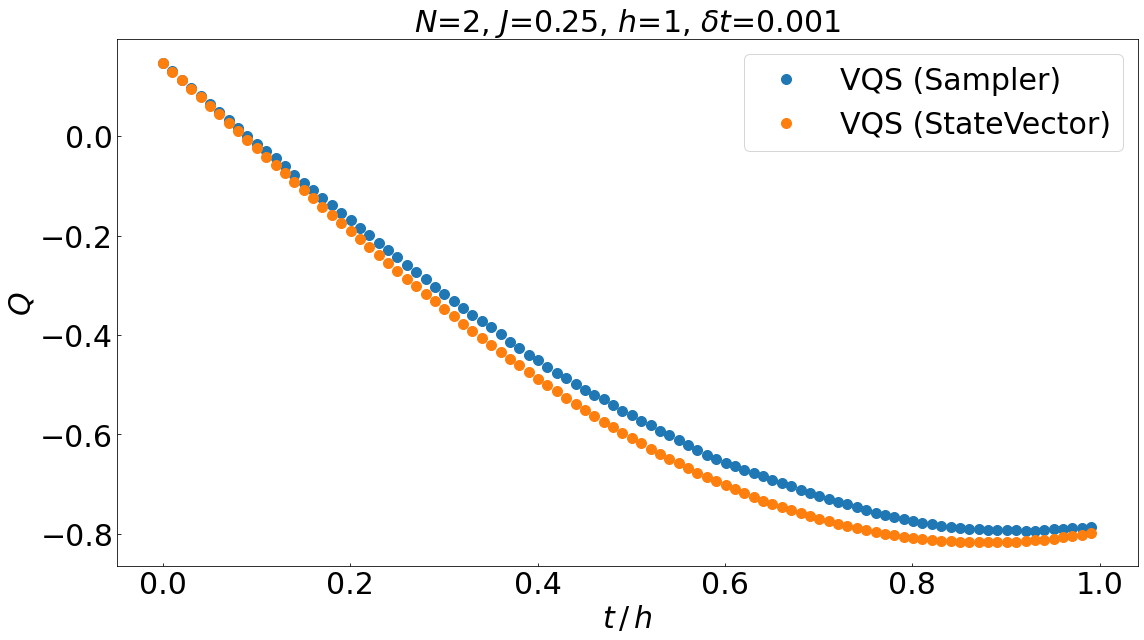

In [317]:

plt.figure(1)
LabelSize=30
plt.figure(figsize=(16,9))

plt.plot(times_VQS[::step],mag_list_VQS[::step],'.',label='VQS (Sampler)',ms=20)
plt.plot(times_VQS[::step],mag_list_VQS_stateVector[::step],'.',label='VQS (StateVector)',ms=20)
plt.title(f'$N$={num_qubits}, $J$={j_coupling}, $h$={h_coupling}, $\delta t$={time_max/num_steps:.3f}',fontsize=LabelSize)
plt.xlabel('$t\, / \, h$',fontsize=LabelSize)
plt.ylabel('$Q$',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize)
plt.tight_layout()
# plt.savefig(f'magnetization_N{num_qubits}_J{j_coupling}_h{h_coupling}_dt{time_max/num_steps:.2f}_v1.pdf')
plt.show()